# Load Forecasting Model

## Importing libraries

In [24]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.model_selection import train_test_split

## Load Dataset

In [25]:
data = pd.read_csv('assignment-data.csv')

 ## Convert datetime column to datetime type

In [26]:
data['datetime'] = pd.to_datetime(data['datetime'])
data.set_index('datetime', inplace=True)

## Basic Data Analysis

In [27]:
data.head()

,Unnamed: 0,load,apparent_temperature,temperature,humidity,dew_point,wind_speed,cloud_cover,date
datetime,,,,,,,,,
2018-01-01 00:00:00,0,803.22270,10.45800,10.45800,0.955500,8.946000,0.0,0.0,2018-01-01
2018-01-01 00:15:00,1,774.89523,10.32675,10.32675,0.961625,8.911875,0.0,0.0,2018-01-01
2018-01-01 00:30:00,2,731.46927,10.19550,10.19550,0.967750,8.877750,0.0,0.0,2018-01-01
2018-01-01 00:45:00,3,713.93870,10.06425,10.06425,0.973875,8.843625,0.0,0.0,2018-01-01
2018-01-01 01:00:00,4,699.23007,9.93300,9.93300,0.980000,8.809500,0.0,0.0,2018-01-01


In [28]:
print("Dataset Summary:\n")
print(data.describe())

Dataset Summary:

          Unnamed: 0           load  apparent_temperature    temperature   
count  103392.000000  101952.000000         103392.000000  103392.000000  \
mean    51695.500000    1558.964330             29.108361      27.100533   
std     29846.843853     531.116557             10.404363       8.489599   
min         0.000000     480.631730              2.173500       3.685500   
25%     25847.750000    1184.992600             20.622000      20.611500   
50%     51695.500000    1496.820000             29.955188      28.638750   
75%     77543.250000    1935.745800             37.474500      33.353250   
max    103391.000000    3230.848600             56.731500      47.943000   

            humidity      dew_point     wind_speed    cloud_cover  
count  103392.000000  103392.000000  103392.000000  103392.000000  
mean        0.602351      15.908390       2.430676       0.329938  
std         0.235507       7.934301       1.366541       0.334558  
min         0.042000     

In [29]:
data.rename(columns={'Unnamed: 0': 'date'}, inplace=True)

In [30]:
print("\nMissing Values Summary:\n")
print(data.isna().sum())


Missing Values Summary:

date                       0
load                    1440
apparent_temperature       0
temperature                0
humidity                   0
dew_point                  0
wind_speed                 0
cloud_cover                0
date                       0
dtype: int64


## Visualizing Load Trends Over Time

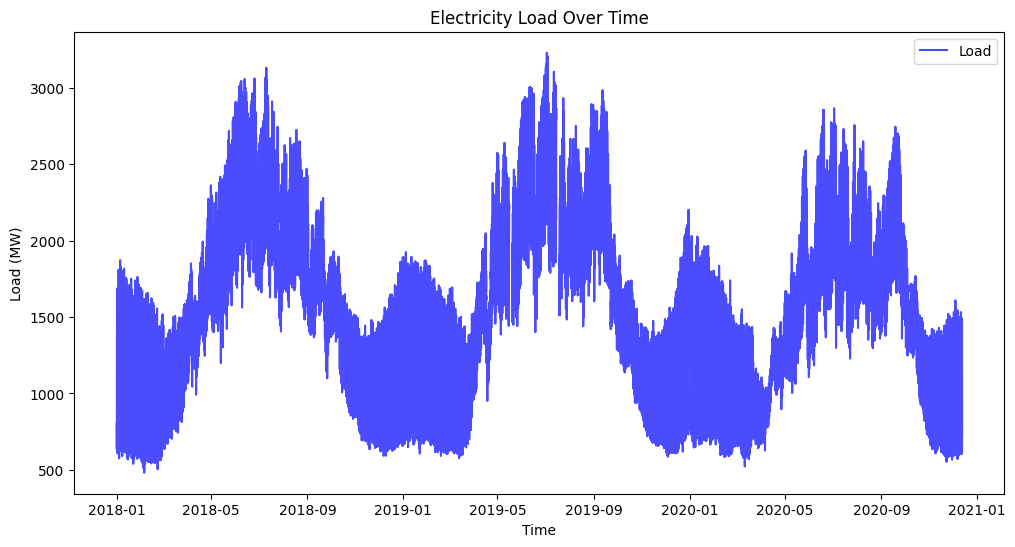

In [31]:
plt.figure(figsize=(12, 6))
plt.plot(data['load'], label='Load', color='blue', alpha=0.7)
plt.title('Electricity Load Over Time')
plt.xlabel('Time')
plt.ylabel('Load (MW)')
plt.legend()
plt.show()

## Visualize Missing Values

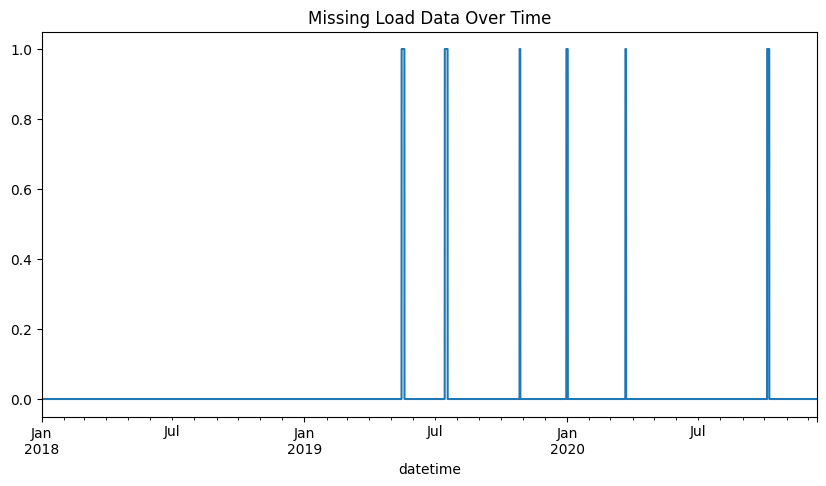

In [32]:
plt.figure(figsize=(10, 5))
plt.title("Missing Load Data Over Time")
data['load'].isna().astype(int).plot()
plt.show()

## Correlation Heatmap

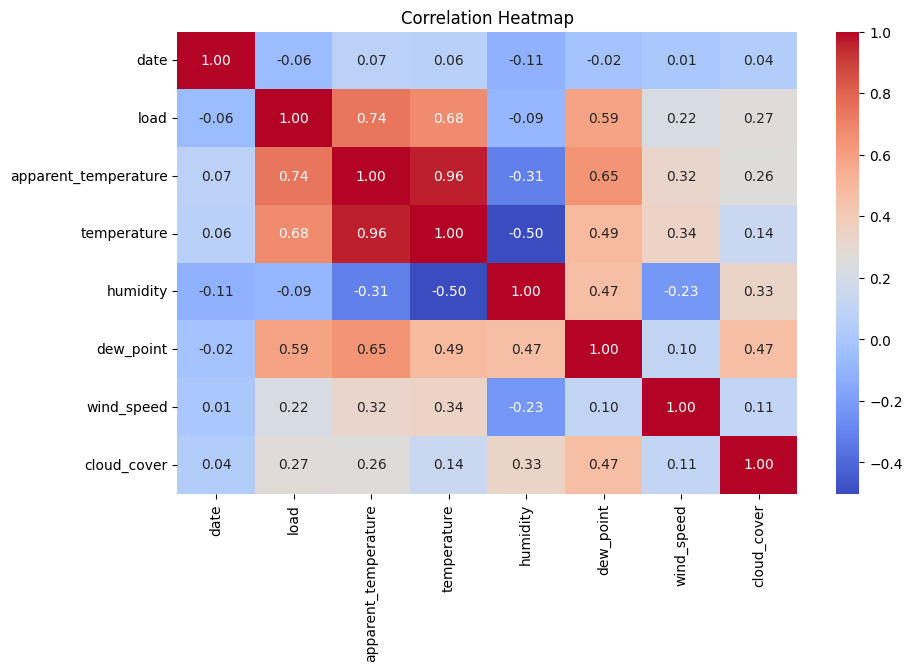

In [33]:
numeric_data = data.select_dtypes(include=[np.number])
plt.figure(figsize=(10, 6))
sns.heatmap(numeric_data.corr(), annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Heatmap')
plt.show()

## Distribution of Load

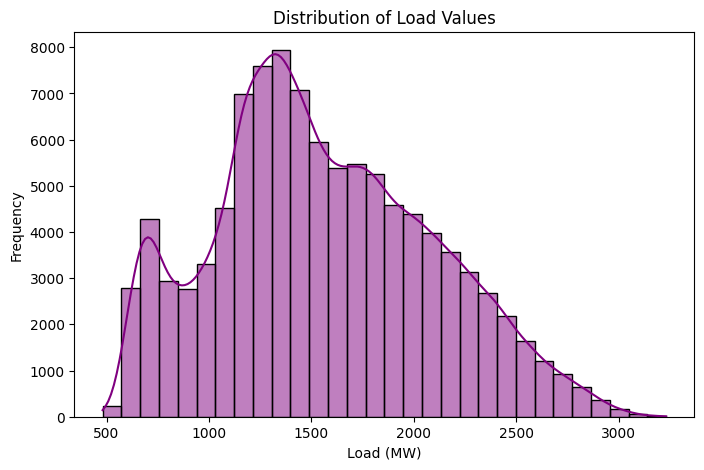

In [34]:
plt.figure(figsize=(8, 5))
sns.histplot(data['load'], kde=True, bins=30, color='purple')
plt.title('Distribution of Load Values')
plt.xlabel('Load (MW)')
plt.ylabel('Frequency')
plt.show()

## Fill Missing Weather Data (if any) using Interpolation

In [35]:
weather_cols = ['apparent_temperature', 'temperature', 'humidity', 'dew_point', 'wind_speed', 'cloud_cover']
data[weather_cols] = data[weather_cols].interpolate(method='time')

## Feature Engineering

In [36]:
data['hour'] = data.index.hour
data['day_of_week'] = data.index.dayofweek
data['is_weekend'] = (data['day_of_week'] >= 5).astype(int)
data['month'] = data.index.month
data['is_holiday'] = data.index.strftime('%Y-%m-%d').isin(["2020-12-25", "2020-08-15", "2020-01-26"]).astype(int)  # Example holidays


# Task 1: Short-Term Forecast for Dec 14, 2020

In [37]:
# Create the forecast date (Dec 14, 2020)
forecast_date = '2020-12-14'

# Use last known data (up to Dec 13, 2020) to train the model
train_data = data[:'2020-12-13']

# Remove rows with NaN values in the target variable
train_data = train_data.dropna(subset=['load'])

# Define Features and Target
X_train = train_data.drop(columns=['load'])
X_train = X_train.select_dtypes(include=[np.number])  # Ensure only numeric columns

y_train = train_data['load']

# Train-Test Split for Validation
X_tr, X_val, y_tr, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

# Model Training
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_tr, y_tr)  # Random Forest Model

# Validate Model
rf_y_pred_val = rf_model.predict(X_val)
rf_validation_mape = mean_absolute_percentage_error(y_val, rf_y_pred_val)
print(f"Random Forest Validation MAPE: {rf_validation_mape:.2f}")


Random Forest Validation MAPE: 0.02


In [38]:

# Task: Forecast for December 14, 2020
forecast_datetime = pd.date_range(start="2020-12-14 00:00:00", periods=96, freq="15T")
forecast_rf_features = pd.DataFrame({
    'hour': forecast_datetime.hour,
    'day_of_week': forecast_datetime.dayofweek,
    'is_weekend': (forecast_datetime.dayofweek >= 5).astype(int),
    'month': forecast_datetime.month,
    'is_holiday': 0  # Assuming no holidays for simplicity
})

# Align features with training data
for col in X_train.columns:
    if col not in forecast_rf_features.columns:
        forecast_rf_features[col] = 0  # Default value for missing columns

forecast_rf_features = forecast_rf_features[X_train.columns]  # Reorder columns

# Forecast
rf_forecast_14dec = rf_model.predict(forecast_rf_features)

# Save the forecast output
forecast_output = pd.DataFrame({'datetime': forecast_datetime, 'forecast': rf_forecast_14dec})
forecast_output.to_csv('forecast_14_Dec_Output.csv', index=False)


print("Forecast for December 14, 2020, saved as 'forecast_14_Dec_Output.csv")


Forecast for December 14, 2020, saved as 'forecast_14_Dec_Output.csv


In [39]:
# Task 2: Fill missing values in the historical data
missing_indices = data['load'].isna()
data['load_filled'] = data['load'].copy()

# Ensure 'load_filled' is excluded during prediction
features_for_prediction = data.loc[missing_indices].drop(columns=['load', 'load_filled']).select_dtypes(include=[np.number])
data.loc[missing_indices, 'load_filled'] = rf_model.predict(features_for_prediction)

# Save the forecast output (both tasks)
forecast_output_task1 = pd.DataFrame({'datetime': forecast_datetime, 'forecast': rf_forecast_14dec})
forecast_output_task2 = data.loc[missing_indices, ['load_filled']].reset_index()
forecast_output_task2.rename(columns={'load_filled': 'forecast', 'datetime': 'datetime'}, inplace=True)

final_forecast_output = pd.concat([forecast_output_task1, forecast_output_task2], ignore_index=True)
final_forecast_output.sort_values(by='datetime', inplace=True)
final_forecast_output.to_csv('final_forecast_output.csv', index=False)

print("Forecast for both tasks saved as 'final_forecast_output.csv'.")

Forecast for both tasks saved as 'final_forecast_output.csv'.
